In [1]:
import os
import pickle
import itertools
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6
rcParams.update({'font.size': 15})
import pandas as pd
import seaborn as sns
from hyperopt import hp, space_eval, Trials
import pprint
pp = pprint.PrettyPrinter(indent=4)
print("Done importing.")

def load_trials(p):
    with open(p, 'rb') as h:
        trials = pickle.load(h)
        return trials
    
def load_space(p):
    with open(p, 'rb') as h:
        sp = pickle.load(h)
        return sp
    
def get_space_vals_sorted(key, trials):
    vals = set()
    for t in trials:
        for x in t.trials:
            vals.add(x['result']['space'][d])
    sorted(vals)
    return vals

Done importing.


In [6]:
fpath_list = [#'/home/kashefy/models/ae/hyper/t0_25/trials.pkl', # for debugging
#               '/home/kashefy/models/ae/mnist/hyper/2017-10-26/trials.pkl',
#                 '/home/kashefy/models/ae/mnist/hyper/2017-10-27/trials.pkl'
#                 '/home/kashefy/models/ae/mnist/hyper/2017-10-27_3/trials.pkl',
#                 '/home/kashefy/models/ae/mnist/hyper/2017-10-31/trials.pkl',
                '/home/kashefy/models/ae/mnist/hyper/2017-11-06rm/trials.pkl',
             ]
trials = []
for p in fpath_list:
    t = load_trials(p)
    print('%s: %d trials.' %(p, len(t)))
    trials.append(t)

/home/kashefy/models/ae/mnist/hyper/2017-11-06rm/trials.pkl: 750 trials.


In [219]:
print("Sets of trials: %d individually: %s" % (len(trials), [len(t) for t in trials]))
# space = load_space('/home/kashefy/models/ae/hyper/t0_25/space.pkl')
# print(space)
for t in trials:
    pp.pprint('best')
    pp.pprint(t.best_trial)
    for x in t.trials:
        pp.pprint(x)
#         pp.pprint(space_eval(space, x))

Sets of trials: 1 individually: [300]
'best'
{   'book_time': datetime.datetime(2017, 11, 1, 0, 56, 28, 69000),
    'exp_key': None,
    'misc': {   'cmd': ('domain_attachment', 'FMinIter_Domain'),
                'idxs': {   'lambda_l2': [84],
                            'learning_rate': [84],
                            'n_nodes': [84]},
                'tid': 84,
                'vals': {   'lambda_l2': [0],
                            'learning_rate': [0],
                            'n_nodes': [3]},
                'workdir': None},
    'owner': None,
    'refresh_time': datetime.datetime(2017, 11, 1, 0, 59, 43, 888000),
    'result': {   'loss': -0.9593200087547302,
                  'name': u'mlp256128/validation/accuracy/value:0',
                  'performance': 0.95932001,
                  'space': {   'batch_size_train': 64,
                               'batch_size_val': 100,
                               'data_dir': 'MNIST_data',
                               'data_see

In [244]:
print("Sets of trials: %d individually: %s" % (len(trials), [len(t) for t in trials]))
# space = load_space('/home/kashefy/models/ae/hyper/t0_25/space.pkl')
# print(space)
for t in trials:
#     pp.pprint(t.best_trial)
    for x in t.trials:
#         if len(x['result']['space']['n_nodes']) > 3 and x['result']['space']['lambda_l2']==0.0005:
#             print(x['result']['space']['n_nodes'], x['result']['space']['lambda_l2'], x['result']['performance'])
#         pp.pprint(space_eval(space, x))
        if np.isclose(x['result']['performance'],0.73787999):
            print(x['result']['space']['n_nodes'], x['result']['space']['lambda_l2'], x['result']['performance'])
        if np.isclose(x['result']['performance'],0.91979998):
            print(x['result']['space']['n_nodes'], x['result']['space']['lambda_l2'], x['result']['performance'])
#         0.73787999, 0.91979998

Sets of trials: 1 individually: [300]
([512, 256], 0.0005, 0.73787999)
([512, 256], 0.0005, 0.91979998)


### Single Dim. Scatter

In [2]:
def get_axis_vals(x):
    def is_numeric_check(a):
        return str(a).replace('.', '').replace('e','').replace('-','').isdigit()
    is_categorical = not is_numeric_check(x[0])
#     print('x', x[0])
#     print(is_categorical)
    lut = {}
    idx = 0
    if is_categorical:
        cat = list([tuple(v) for v in x])
        # category of list/tuples
        if isinstance(cat[0], (list, tuple)) and not isinstance(cat[0], basestring):
            if is_numeric_check(cat[0][0]):
                # list tuples of numbers
                def KeyFunc(el):
#                     print(el)
#                     el_str = ''.join([str(abs(el_x)) for el_x in el])
#                     return int(el_str)
#                     el_prod = reduce(lambda x, y: x * y, el, 1)
                    # sum of products of adjacent elements (i.e. no. of weights in network)
                    el_sum_prod = sum([el_x * el_y for el_x, el_y in zip(el[:-1], el[1:])])
#                     print(el,el_sum_prod)
                    return el_sum_prod
                cat = sorted(cat, key=KeyFunc)
            else:
                cat = sorted(cat, key=len)
        vals = []
        for c in cat:
            if isinstance(c, (list, tuple)) and not isinstance(c, basestring):
                c = str(c)
            if c not in lut:
                lut[c] = idx
                idx += 1
            vals.append(lut[c])
    else:
        vals = list(x)
        cat = vals
        for c in sorted(cat):
            if c not in lut:
                lut[c] = idx
                idx += 1
    return is_categorical, vals, cat, lut

In [3]:
def single_dim_scatter(results_per_dim, dim_name, perf_name):
    results_dim = results_per_dim[dim_name]
    is_x_categorical, x_vals, x_cat, _ = get_axis_vals([x for x, _ in results_dim])
    plt.scatter(x_vals, [[y for _, y in results_dim]])
    # plt.xlim([space_vals[0], space_vals[-1]])
    if is_x_categorical:
        # remove duplicates to get rid of bold axis labels
        assert(len(x_cat)==len(x_vals))
#         print(x_cat)
#         print(x_vals)
        x_set = set(tuple([v, c]) for v, c in zip(x_vals, x_cat))
        plt.xticks([tick for tick, _ in x_set], [label for _, label in x_set])
    plt.xlabel(dim_name.replace('_', ' '))
    if is_x_categorical:
        plt.xticks(rotation='vertical')
    plt.ylabel(perf_name)

### Single Dim. Box plot

In [4]:
def single_dim_box(results_per_dim, dim_name, perf_name):
    results_dim = results_per_dim[dim_name]
    is_x_categorical, x_vals, x_cat, _ = get_axis_vals([x for x, _ in results_dim])
    y_vals = [y for _, y in results_dim]
    if is_x_categorical:
        data = [[] for _ in range(max(x_vals)+1)]
        labels = [[] for _ in range(len(data))]
        for val, cat, y_val in zip(x_vals, x_cat, y_vals):
            data[val].append(y_val)
            labels[val] = cat
    else:
        x_vals_lut = {}
        for val, y_val in zip(x_vals, y_vals):
            if val not in x_vals_lut:
                x_vals_lut[val] = []
            x_vals_lut[val].append(y_val)
        keys = sorted(x_vals_lut.keys())
        data = []
        labels = []
        for kidx, k in enumerate(keys):
            data.append(x_vals_lut[k])
            labels.append(k)
    plt.boxplot(data, 1, labels=labels,)
    if is_x_categorical:
        plt.xticks(rotation='vertical')
    plt.xlabel(dim_name.replace('_', ' '))
    plt.ylabel(perf_name)

### Visualize Single Dim.

Sets of trials: 1 individually: [300]


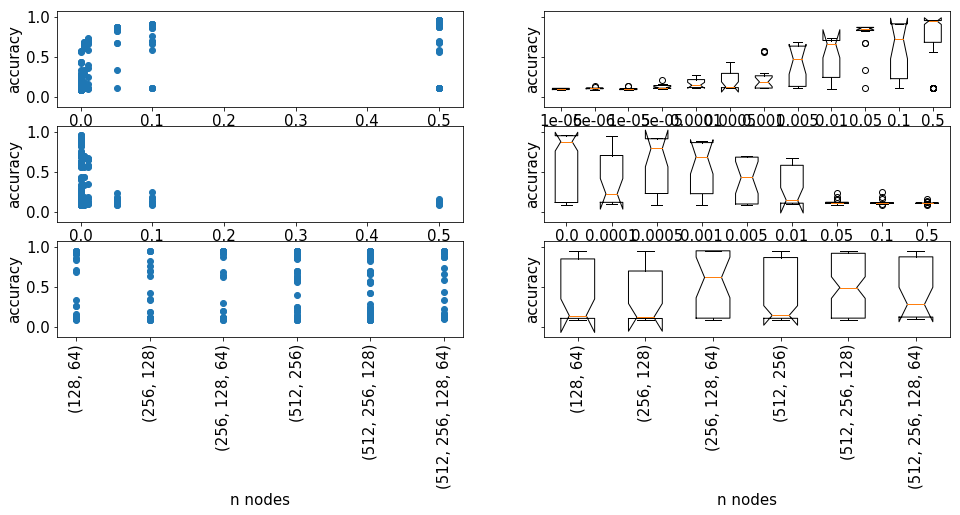

In [142]:
print("Sets of trials: %d individually: %s" % (len(trials), [len(t) for t in trials]))
space_dim_names = ['learning_rate', 'lambda_l2', 'n_nodes']
results_per_dim = {k:[] for k in space_dim_names}
for t in trials:
    for x in t.trials:
        for d in space_dim_names:
            point_in_space = x['result']['space'][d]
            perf = x['result']['performance']
            results_per_dim[d].append([point_in_space, perf])
fig, axs = plt.subplots(len(space_dim_names), 2, sharey=True)
for didx, d in enumerate(space_dim_names):
    plt.sca(axs[didx][0])
    single_dim_scatter(results_per_dim, d, 'accuracy')
    plt.sca(axs[didx][1])
    single_dim_box(results_per_dim, d, 'accuracy')
# plt.tight_layout()
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### 2-dim Visualization

In [5]:
for t in trials:
#     pp.pprint(t.best_trial)
    for x in t.trials:
#         if len(x['result']['space']['n_nodes']) > 3 and x['result']['space']['lambda_l2']==0.0005:
#             print(x['result']['space']['n_nodes'], x['result']['space']['lambda_l2'], x['result']['performance'])
#         pp.pprint(space_eval(space, x))
        if np.isclose(x['result']['performance'],0.73787999):
            print(x['result']['space']['n_nodes'], x['result']['space']['lambda_l2'], x['result']['performance'])
        if np.isclose(x['result']['performance'],0.91979998):
            print(x['result']['space']['n_nodes'], x['result']['space']['lambda_l2'], x['result']['performance'])
#         0.73787999, 0.91979998

def dimvecs(results_per_point, dim_names, perf_name):
    print(results_per_point)
    results_per_point = results_per_point[dim_names]
    for a,b in results_per_point:
#         if a[0] == 0.0005 and len(a[1]) >3:
#             print(b)
            
        if np.isclose(x['result']['performance'],0.73787999):
            print(x['result']['space']['n_nodes'], x['result']['space']['lambda_l2'], x['result']['performance'])
        if np.isclose(x['result']['performance'],0.91979998):
            print(x['result']['space']['n_nodes'], x['result']['space']['lambda_l2'], x['result']['performance'])
    assert(len(dim_names)==len(results_per_point[0][0]))
    Points = collections.namedtuple('Dim', ['val', 'cat', 'lut', 'is_categorical'])
    p = {}
    pn = {}
    pos = []
    for didx, dname in enumerate(dim_names):
        is_x_categorical, x_vals, x_cat, x_lut = get_axis_vals([x[didx] for x, _ in results_per_point])
#         print(dname,x_lut)
#         print(x_lut)
        if is_x_categorical:
            x_lut_nums = {}
            for k in x_lut.keys():
#                 lut_rev[x_lut[k]] = k
                x_lut_nums[x_lut[k]] = x_lut[k]
#             print(lut_rev)
#             x_lut_nums = lut_rev
#             pn[dname] = x_lut_nums
            pos.append([x_lut_nums[v] for v in x_vals])
        else:
            pos.append([x_lut[v] for v in x_vals])
#         print(x_lut)
        p[dname] = Points(val=x_vals, cat=x_cat, lut=x_lut, is_categorical=is_x_categorical)
    vals_per_dim = [len(p[dname].lut.keys()) for dname in dim_names]
    heat_vecs = np.empty(vals_per_dim, dtype=object)
    ht_vals = [ht for _, ht in results_per_point]
    pos = np.array(pos).T
    for i in range(heat_vecs.size):
        heat_vecs.ravel()[i] = []
    for idx, v in enumerate(pos):
        heat_vecs[tuple(v)].append(ht_vals[idx])
    return heat_vecs, pos, [p[dname].lut for dname in dim_names]

print("Sets of trials: %d individually: %s" % (len(trials), [len(t) for t in trials]))
space_dim_names = ['lambda_l2', 'n_nodes']#['learning_rate', 'lambda_l2', 'n_nodes']
dim_name_pairs = list(itertools.combinations(space_dim_names, 2))
results_per_point = {k:[] for k in dim_name_pairs}
for t in trials:
    for x in t.trials:
        for key in results_per_point.keys():
            point_in_space = [x['result']['space'][key_el] for key_el in key]
            perf = x['result']['performance']
#             print('point',point_in_space, perf)
            results_per_point[key].append([point_in_space, perf])
# print(results_per_point)
for pair in dim_name_pairs:
    heat_vecs, idxs, labels_lut = dimvecs(results_per_point, pair, 'accuracy')

NameError: name 'trials' is not defined

Sets of trials: 1 individually: [300]
[[-1.          0.66052997  0.71118158  0.59876812  0.65017521  0.5078184 ]
 [ 0.11681     0.37228     0.51065999  0.54482853  0.46018001  0.58825999]
 [ 0.85329324  0.40514001  0.56414002  0.58099425  0.6301133   0.82884002]
 [ 0.55291998  0.39592001  0.36767998  0.67654282  0.504408    0.62186664]
 [ 0.38661999  0.32658663  0.68724     0.2551257   0.54699332  0.39046001]
 [ 0.12401333  0.19164     0.37562001  0.26980001  0.428408    0.62404001]
 [ 0.10776     0.13873334  0.0896      0.10598857  0.14272667  0.12894   ]
 [ 0.10741333  0.0997      0.1098      0.11106856  0.15642665  0.10882001]
 [ 0.1098      0.10820001  0.11684     0.10278857  0.12003333  0.12144   ]]
[{0.0: 0, 0.5: 8, 0.0005: 2, 0.1: 7, 0.05: 6, 0.001: 3, 0.0001: 1, 0.005: 4, 0.01: 5}, {'(512, 256, 128)': 4, '(512, 256)': 3, '(256, 128)': 1, '(512, 256, 128, 64)': 5, '(128, 64)': 0, '(256, 128, 64)': 2}]
(0, array([ list([0.95076001, 0.10776, 0.34011999, 0.94904, 0.94936001, 0.9485

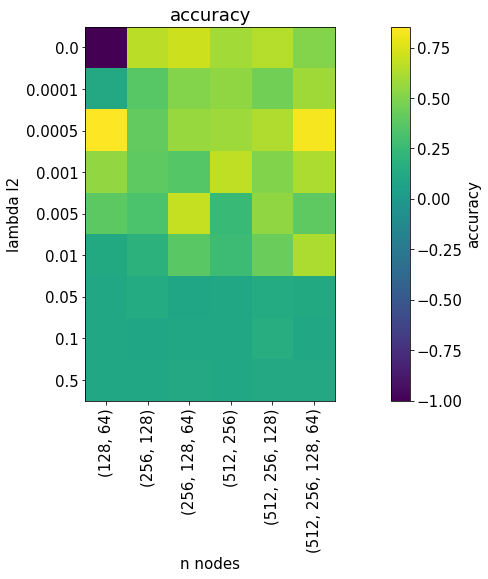

In [239]:
def heat(results_per_point, dim_names, perf_name):
    assert(len(dim_names)==2)
    heat_vecs, idxs, labels_lut = dimvecs(results_per_point, dim_names, perf_name)
#     print(heat_vecs, idxs, labels_lut)
#     print(heat_vecs, len(idxs), labels_lut)
#     print(len(idxs), labels_lut)
#     print(len(idxs), heat_vecs.shape)
    assert(heat_vecs.ndim==2)
    heat = np.zeros(heat_vecs.shape)-999.
    for idx in xrange(heat.size):
        if len(heat_vecs.ravel()[idx]) > 0:
            heat.ravel()[idx] = np.mean(heat_vecs.ravel()[idx])
    heat[(heat < 0).astype(bool)] = np.nan
    current_cmap = matplotlib.cm.get_cmap()
    current_cmap.set_bad(color='white')
    heat[0,0] = -1
#     print(dim_names)
    print(heat)
    print(labels_lut)
    for idx in range(len(heat_vecs)):
        print(idx, heat_vecs[idx])
    plt.imshow(heat, interpolation='none', aspect='equal')
    plt.tight_layout()
    labels_lut_rev = []
    for l in labels_lut:
        lut_rev = {}
        for k in l.keys():
            lut_rev[l[k]] = k
        labels_lut_rev.append(lut_rev)
#     pp.pprint(labels_lut)
#     print(labels_lut_rev[1])
    x_idxs = sorted(labels_lut_rev[1].keys())
    x_labels = [labels_lut_rev[1][l] for l in x_idxs]
    y_idxs = sorted(labels_lut_rev[0].keys())
    y_labels = [labels_lut_rev[0][l] for l in y_idxs]
#     print('x', x_idxs, x_labels)
#     print(sorted(labels_lut_rev[0].keys()))
#     print('y',y_idxs, y_labels)
    plt.xticks(x_idxs, x_labels, rotation='vertical')
    argsrt = np.argsort(y_labels)
#     print('ast',np.array(y_labels)[argsrt])
    plt.yticks(argsrt, np.array(y_labels)[argsrt])
    plt.xlabel(dim_names[1].replace('_', ' '))
    plt.ylabel(dim_names[0].replace('_', ' '))
    plt.title(perf_name)
    cb = plt.colorbar()
    cb.set_label(perf_name)

print("Sets of trials: %d individually: %s" % (len(trials), [len(t) for t in trials]))
space_dim_names = ['lambda_l2', 'n_nodes']#['learning_rate', 'lambda_l2', 'n_nodes']
dim_name_pairs = list(itertools.combinations(space_dim_names, 2))
results_per_point = {k:[] for k in dim_name_pairs}
for t in trials:
    for x in t.trials:
        for key in results_per_point.keys():
            point_in_space = [x['result']['space'][key_el] for key_el in key]
            perf = x['result']['performance']
#             print('point',point_in_space, perf)
            results_per_point[key].append([point_in_space, perf])
# print(results_per_point)
for pair in dim_name_pairs:
    plt.figure()
    heat(results_per_point, pair, 'accuracy')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# We chose just a few params to inspect not to bloat the scatterplot:
int_params_names_to_correlate = [
    'learning_rate',
]

params_values = [[neural_net["space"][p] for neural_net in jsons] for p in int_params_names_to_correlate]
best_accs = [neural_net["fine_best_accuracy"] for neural_net in jsons]


def scatterplot_matrix_colored(params_names, params_values, best_accs, blur=False):
    """Scatterplot colored according to the Z values of the points."""
    
    nb_params = len(params_values)
    best_accs = np.array(best_accs)
    norm = matplotlib.colors.Normalize(vmin=best_accs.min(), vmax=best_accs.max())
    
    fig, ax = plt.subplots(nb_params, nb_params, figsize=(16, 16))#, facecolor=bg_color, edgecolor=fg_color)
    
    for i in range(nb_params):
        p1 = params_values[i]
        for j in range(nb_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            # Subplot:
            if blur:
                s = axes.scatter(p2, p1, s=400, alpha=.1,
                                 c=best_accs, cmap='viridis', norm=norm)
                s = axes.scatter(p2, p1, s=200, alpha=.2,
                                 c=best_accs, cmap='viridis', norm=norm)
                s = axes.scatter(p2, p1, s=100, alpha=.3,
                                 c=best_accs, cmap='viridis', norm=norm)
            s = axes.scatter(p2, p1, s=15,
                             c=best_accs, cmap='viridis', norm=norm)

            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=0)
            else:
                axes.set_yticks([])
            
            if i == nb_params - 1:
                axes.set_xlabel(params_names[j], rotation=90)
            else:
                axes.set_xticks([])

    fig.subplots_adjust(right=0.82, top=0.95)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of tried values in the search space over different params, colored in function of best test accuracy')
    plt.show()


scatterplot_matrix_colored(int_params_names_to_correlate, params_values, best_accs, blur=True)
scatterplot_matrix_colored(int_params_names_to_correlate, params_values, best_accs, blur=False)

# Analysis via Pandas

## Construct DataFrame

In [62]:
df = pd.DataFrame({})
space_dim_names = ['learning_rate', 'lambda_l2', 'n_nodes']
df['performance'] = [x['result']['performance'] for x in t.trials]
for dname in space_dim_names:
    print(dname)
#     x = [x['result']['space'][dname] for t in trials for x in t.trials]
    x = [x['result']['space'][dname] for x in t.trials]
    x = [str(a) if isinstance(a, (list, tuple)) and not isinstance(a, basestring) else a for a in x]
    df[dname] = x
# handle case of categorical n_nodes
if 'n_nodes' in df and 'num_weights' not in df:
    def count_weights(a):
        a = [int(x.strip()) for x in a.strip('[').strip(']').split(',')]
        return sum([el_x * el_y for el_x, el_y in zip(a[:-1], a[1:])])
#     df['num_weights'] = [count_weights(a) for a in df['n_nodes']]
    df['num_weights'] = df['n_nodes'].apply(lambda x: count_weights(x))
print(df.describe())


learning_rate
lambda_l2
n_nodes
       performance  learning_rate   lambda_l2    num_weights
count   750.000000     750.000000  750.000000     750.000000
mean      0.494820       0.208230    0.042826   64509.269333
std       0.373358       0.238306    0.122506   56418.758739
min       0.070600       0.000001    0.000000    8192.000000
25%       0.112000       0.000100    0.000000   32768.000000
50%       0.421400       0.050000    0.000100   32768.000000
75%       0.916650       0.500000    0.010000  131072.000000
max       0.964000       0.500000    0.500000  172032.000000


## Single Dim

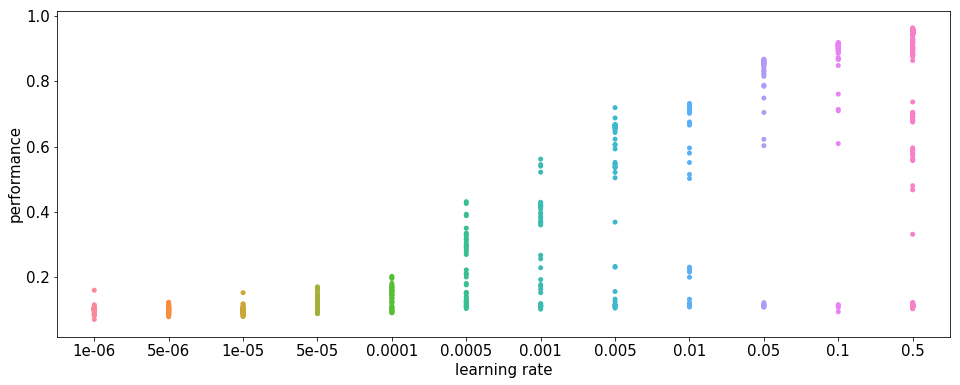

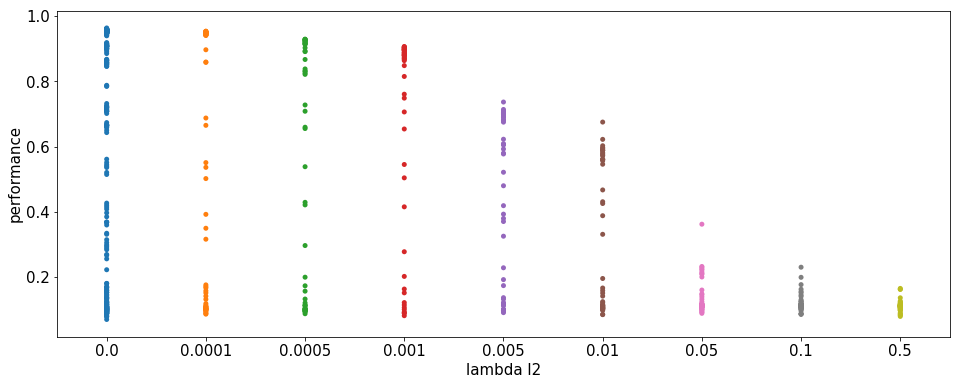

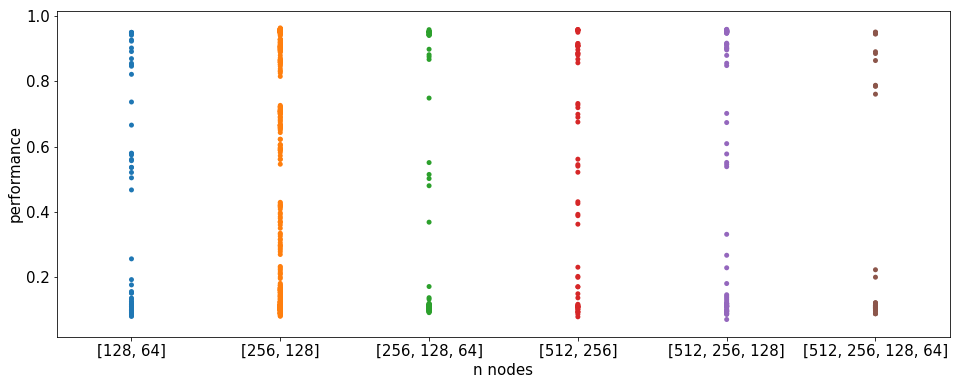

In [63]:
for dname in space_dim_names:
    plt.figure()
    if dname == 'n_nodes':
        dsubst = 'num_weights'
        ax = sns.stripplot(x=dsubst, y="performance", data=df)
        labels = [df[df[dsubst]==int(l.get_text())].iloc[0][dname] for l in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
    else:    
        ax = sns.stripplot(x=dname, y="performance", data=df)
    ax.set(xlabel=dname.replace('_', ' '))

## 2-dim Vis

('learning_rate', 'lambda_l2')
h
     performance  learning_rate  lambda_l2              n_nodes  num_weights
13        0.1374       0.000050     0.0050       [256, 128, 64]        40960
37        0.0998       0.000005     0.0050       [256, 128, 64]        40960
79        0.1128       0.001000     0.0100       [256, 128, 64]        40960
98        0.0944       0.100000     0.0500           [512, 256]       131072
133       0.2782       0.000500     0.0010           [256, 128]        32768
155       0.2972       0.000500     0.0005           [256, 128]        32768
242       0.1018       0.000001     0.0500           [512, 256]       131072
287       0.7066       0.010000     0.0010           [256, 128]        32768
372       0.4158       0.001000     0.0010           [256, 128]        32768
388       0.0886       0.000005     0.1000           [256, 128]        32768
570       0.1152       0.100000     0.1000           [256, 128]        32768
606       0.8972       0.100000     0.0001 

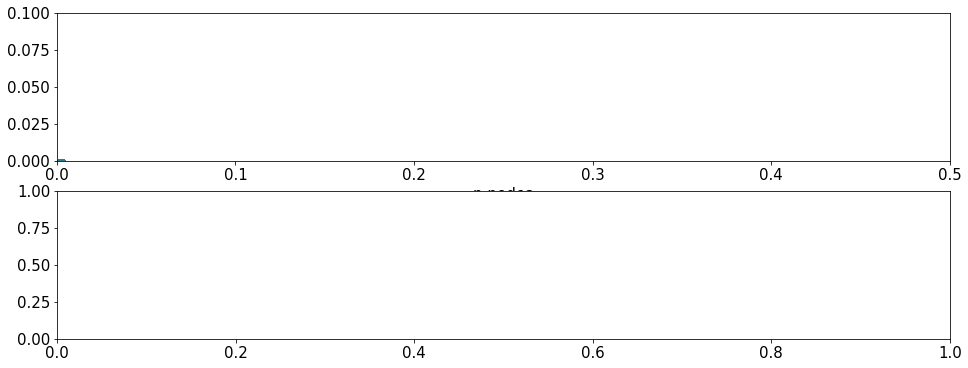

In [64]:
space_dim_names = ['learning_rate', 'lambda_l2']#, 'n_nodes']
dim_name_pairs = list(itertools.combinations(space_dim_names, 2))
fig, axes = plt.subplots(len(space_dim_names), 1)
for ax_idx, (dimX, dimY) in enumerate(dim_name_pairs):
    ax = axes[ax_idx]
    print(dimX, dimY)
    if dimX == 'n_nodes':
        dimXsubst = 'num_weights'
        df.plot(kind="scatter",
                x=dimXsubst, y=dimY, s=50, c="performance",
                cmap="plasma",
                ax=ax)
#         labels = [df[df[dimXsubst]==int(l.get_text())].iloc[0][dimX] for l in ax.get_xticklabels()]
#         ax.set_xticklabels(labels)
    elif dimY == 'n_nodes':
        dimYsubst = 'num_weights'
        df.plot(kind="scatter",
                x=dimX, y=dimYsubst, s=50, c="performance",
                cmap="plasma",
                ax=ax)
#         labels = [df[df[dimYsubst]==int(l.get_text())].iloc[0][dimY] for l in ax.get_xticklabels()]
#         ax.set_yticklabels(labels)
    else:
#         df.plot(kind="scatter",
#                 x=dimX, y=dimY, s=50, c="performance",
#                 cmap="plasma",
#                 ax=ax)
#         X = df[dimX].values
#         Y = df[dimY].values
        
        
#         Z = df.performance
#         x, y = np.meshgrid(X, Y)
#         plt.contourf(x, y, Z) #the NAN will be plotted as white spaces
        print('h')
        dfd = df.drop_duplicates(subset=[dimX, dimY], keep=False)
        print(dfd)
        dfd=dfd.pivot(dimX, dimY, 'performance')
        print(dfd)
        X=dfd.columns.values
        Y=dfd.index.values
        Z=dfd.values
        x,y=np.meshgrid(X, Y)
        ax.contourf(x, y, Z)
        print(X)
        print(Y)
        print(Z)
#         ax.scatter(X,Y,Z)
#         ax.imshow(Z)
    ax.set(xlabel=dname.replace('_', ' '))
#     df.plot.scatter(x=dimX, y=dimY, sharex=False)#, c='performance');
#     df.plot.scatter(x=dimX, y=dimY, c='performance', sharex=False)#, c='performance');
#     df.plot.scatter(x=dimY, y=dimX)#, c='performance');

('learning_rate', 'lambda_l2')
('learning_rate', 'n_nodes')
('lambda_l2', 'n_nodes')


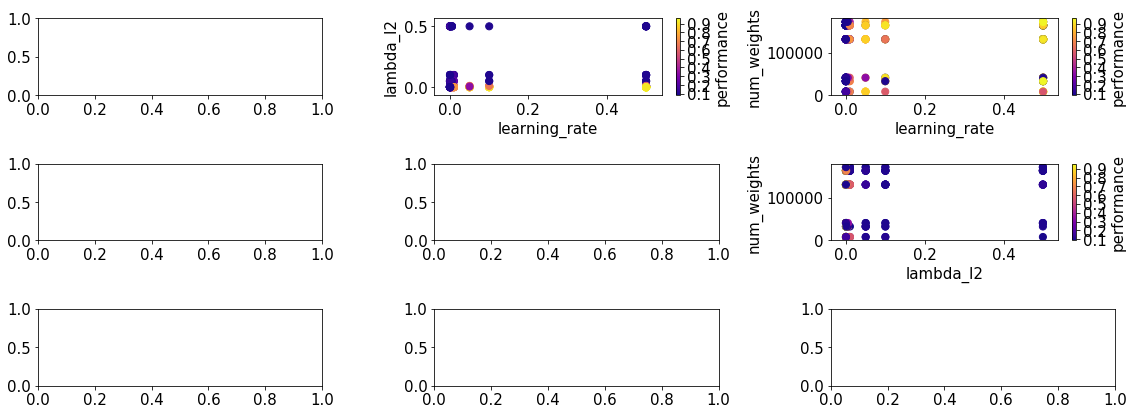

In [151]:
space_dim_names = ['learning_rate', 'lambda_l2', 'n_nodes']
dim_name_pairs = list(itertools.combinations(space_dim_names, 2))
fig, axes = plt.subplots(len(space_dim_names), len(space_dim_names))
for dimX, dimY in dim_name_pairs:
    print(dimX, dimY)
    if dimX == 'n_nodes':
        dimXsubst = 'num_weights'
        ax = axes[space_dim_names.index(dimX)][space_dim_names.index(dimY)]
        df.plot(kind="scatter",
                x=dimXsubst, y=dimY, s=50, c="performance",
                cmap="plasma",
                ax=ax);
    elif dimY == 'n_nodes':
        dimYsubst = 'num_weights'
        ax = axes[space_dim_names.index(dimX)][space_dim_names.index(dimY)]
        df.plot(kind="scatter",
                x=dimX, y=dimYsubst, s=50, c="performance",
                cmap="plasma",
                ax=ax);
    else:
        ax = axes[space_dim_names.index(dimX)][space_dim_names.index(dimY)]
        df.plot(kind="scatter",
                x=dimX, y=dimY, s=50, c="performance",
                cmap="plasma",
                ax=ax);
    plt.tight_layout()
#     df.plot.scatter(x=dimX, y=dimY, sharex=False)#, c='performance');
#     df.plot.scatter(x=dimX, y=dimY, c='performance', sharex=False)#, c='performance');
#     df.plot.scatter(x=dimY, y=dimX)#, c='performance');

## Inter trials

In [252]:
fpath_list = [#'/home/kashefy/models/ae/hyper/t0_25/trials.pkl', # for debugging
#               '/home/kashefy/models/ae/mnist/hyper/2017-10-26/trials.pkl',
#                 '/home/kashefy/models/ae/mnist/hyper/2017-10-27/trials.pkl'
#                 '/home/kashefy/models/ae/mnist/hyper/2017-10-27_3/trials.pkl',
#                 '/home/kashefy/models/ae/mnist/hyper/2017-10-31/trials.pkl',
    
                '/home/kashefy/models/ae/mnist/hyper/2017-11-06a/trials.pkl',
                '/home/kashefy/models/ae/mnist/hyper/2017-11-06ar/trials.pkl',
                '/home/kashefy/models/ae/mnist/hyper/2017-11-06rm/trials.pkl',
                '/home/kashefy/models/ae/mnist/hyper/2017-11-06rm_ro/trials.pkl',
                '/home/kashefy/models/ae/mnist/hyper/2017-11-06rm_o/trials.pkl',
             ]
frames = []
for p in fpath_list:
    df = pd.DataFrame({})
    t = load_trials(p)
    print('%s: %d trials.' %(p, len(t)))
    space_dim_names = ['learning_rate', 'lambda_l2', 'n_nodes']
#     print(t.trials[0]['result'])
#     print([x['result']['performance'] for x in t.trials])
    df['performance'] = [x['result']['performance'] for x in t.trials]
    perf_orient = [x['result']['performance_orient'] for x in t.trials if 'performance_orient' in x['result']]
    if len(perf_orient) == 0:
        perf_orient = [np.nan]*len(t.trials)
    df['performance_orient'] = perf_orient
#     print(df)
    for dname in space_dim_names:
        print(dname)
        x = [x['result']['space'][dname] for x in t.trials]
        x = [str(a) if isinstance(a, (list, tuple)) and not isinstance(a, basestring) and len(a) > 0 else a for a in x]
#         if dname == 'n_nodes':
#             print(x)
        if dname == 'n_nodes' and (len(x) == 0 or (len(x) > 0 and x == [[]]*len(x))):
            x = [x['result']['space']['stack_dims'] for x in t.trials]
#             print(t.trials[0])
            x = [str(a) if isinstance(a, (list, tuple)) and not isinstance(a, basestring) else a for a in x]
        df[dname] = x
#         print(dname, x, [os.path.basename(os.path.dirname(p))]*3, len(x))
        assert(len(x))
        run_name = os.path.basename(os.path.dirname(p))
        df['run_name'] = [run_name]*len(x)
        is_recognition = not run_name.endswith('_o') or run_name.endswith('_rm')
        df['task_recognition'] = [is_recognition]*len(x)
        is_orientation = run_name.endswith('_o') or run_name.endswith('_ro')
        df['task_orientation'] = [is_orientation]*len(x)
        is_augmented = run_name.endswith('ar') or 'rm_' in run_name
        df['is_augmented'] = [is_augmented]*len(x)
    # handle case of categorical n_nodes
    if 'n_nodes' in df and 'num_weights' not in df:
        def count_weights(a):
            print(a)
            a = [int(x.strip()) for x in a.replace('(', '').replace(')', '').replace('[', '').replace(']', ',').split(',') if len(x) > 0]
            print(a)
            return sum([el_x * el_y for el_x, el_y in zip(a[:-1], a[1:])])
    #     df['num_weights'] = [count_weights(a) for a in df['n_nodes']]
        df['num_weights'] = df['n_nodes'].apply(lambda x: count_weights(x))
    frames.append(df)
df = pd.concat(frames)
# print(df.query('task_recognition == False and task_orientation == True'))['performance']
print(df)

/home/kashefy/models/ae/mnist/hyper/2017-11-06a/trials.pkl: 600 trials.
learning_rate
lambda_l2
n_nodes
[512, 256, 128]
[512, 256, 128]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256]
[512, 256]
[(256, 128)]
[256, 128]
[256, 128]
[256, 128]
[256, 128, 64]
[256, 128, 64]
[128, 64]
[128, 64]
[(256, 128), 64]
[256, 128, 64]
[(512, 256), 128]
[512, 256, 128]
[(128, 64)]
[128, 64]
[(512, 256, 128), 64]
[512, 256, 128, 64]
[(256, 128)]
[256, 128]
[(512, 256)]
[512, 256]
[512, 256, 128, 64]
[512, 256, 128, 64]
[(512, 256), 128]
[512, 256, 128]
[(128, 64)]
[128, 64]
[(512, 256)]
[512, 256]
[256, 128, 64]
[256, 128, 64]
[(512, 256)]
[512, 256]
[(512, 256), 128]
[512, 256, 128]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256, 128]
[512, 256, 128]
[512, 256]
[512, 256]
[(512, 256, 128), 64]
[512, 256, 128, 64]
[(256, 128), 64]
[256, 128, 64]
[128, 64]
[128, 64]
[256, 128]
[256, 128]
[512, 256, 128]
[5

[(128, 64)]
[128, 64]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[(256, 128), 64]
[256, 128, 64]
[(512, 256, 128), 64]
[512, 256, 128, 64]
[128, 64]
[128, 64]
[(512, 256), 128]
[512, 256, 128]
[512, 256]
[512, 256]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[(256, 128)]
[256, 128]
[(512, 256)]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256, 128]
[512, 256, 128]
[256, 128, 64]
[256, 128, 64]
[(128, 64)]
[128, 64]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[512, 256]
[512, 256]
[(256, 128), 64]
[256, 128, 64]
[(512, 256, 128), 64]
[512, 256, 128, 64]
[(512, 256), 128]
[512, 256, 128]
[512, 256]
[512, 256]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256]
[512, 256]
[(512, 256)]
[512, 256]
[512, 256]
[512, 256]
[(256, 128)]
[256, 128]
[512, 256]
[512, 256]
[512, 256, 128]
[512, 256, 128]
[256, 128, 64]
[256, 128, 64]
[512, 256]
[512, 256]
[(128, 64)]
[128, 64]
[256, 128]
[256, 128]
[512

/home/kashefy/models/ae/mnist/hyper/2017-11-06rm/trials.pkl: 1350 trials.
learning_rate
lambda_l2
n_nodes
[256, 128, 64]
[256, 128, 64]
[256, 128, 64]
[256, 128, 64]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256, 128]
[512, 256, 128]
[128, 64]
[128, 64]
[512, 256]
[512, 256]
[128, 64]
[128, 64]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256]
[512, 256]
[256, 128, 64]
[256, 128, 64]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256]
[512, 256]
[256, 128, 64]
[256, 128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[256, 128, 64]
[256, 128, 64]
[128, 64]
[128, 64]
[128, 64]
[128, 64]
[512, 256]
[512, 256]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256]
[512, 256]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256, 128]
[5

[256, 128, 64]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[512, 256, 128, 64]
[512, 256, 128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128, 64]
[256, 128, 64]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256, 128, 64]
[512, 256, 128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128, 64]
[256, 128, 64]
[128, 64]
[128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256, 128, 64]
[512, 256, 128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128, 64]
[256, 128, 64]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256, 12

[256, 128, 64]
[256, 128, 64]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[128, 64]
[128, 64]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256, 128]
[512, 256, 128]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256, 128, 64]
[512, 256, 128, 64]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128, 64]
[256, 128, 64]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[128, 64]
[128, 64]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[512, 256]
[51

/home/kashefy/models/ae/mnist/hyper/2017-11-06rm_o/trials.pkl: 200 trials.
learning_rate
lambda_l2
n_nodes
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256, 128]
[512, 256, 128]
[128, 64]
[128, 64]
[256, 128, 64]
[256, 128, 64]
[256, 128, 64]
[256, 128, 64]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[512, 256, 128, 64]
[512, 256, 128, 64]
[512, 256]
[512, 256]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[512, 256, 128]
[128, 64]
[128, 64]
[128, 64]
[128, 64]
[512, 256, 128, 64]
[512, 256, 128, 64]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[256, 128]
[256, 128]
[256, 128, 64]
[256, 128, 64]
[512, 256]
[512, 256]
[128, 64]
[128, 64]
[512, 256, 128, 64]
[512, 256, 128, 64]
[128, 64]
[128, 64]
[256, 128]
[256, 128]
[128, 64]
[128, 64]
[256, 128, 64]
[256, 128, 64]
[512, 256]
[512, 256]
[256, 128

performance_x           float64
performance_orient_y    float64
dtype: object


,performance_x,performance_orient_y
performance_x,1.000000,0.968481
performance_orient_y,0.968481,1.000000


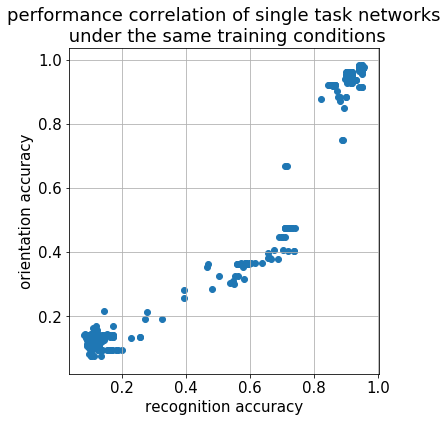

In [223]:
# space_dim_names = ['learning_rate', 'lambda_l2', 'n_nodes']
# space_dim_names = ['learning_rate', 'lambda_l2', 'n_nodes', 'run_name']
space_dim_names = ['learning_rate', 'lambda_l2', 'num_weights', 'performance', 'performance_orient']
fig, ax = plt.subplots(1, 1)
dfd_ro = df.query('task_recognition == True and task_orientation == True')[space_dim_names]#.loc[:20]
dfd_o = df.query('task_recognition == False and task_orientation == True')[space_dim_names]#.loc[:20]
dfd_r = df.query('task_recognition == True and task_orientation == False')[space_dim_names]#.loc[:20]
# print('ro')
# print(dfd_ro)
# print('o')
# print(dfd_o.describe())
s1 = pd.merge(dfd_r, dfd_o, how='inner', on=['learning_rate', 'lambda_l2', 'num_weights'])
plt.axes().set_aspect('equal')
plt.scatter(s1.performance_x, s1.performance_orient_y)
plt.xlabel('recognition accuracy')
plt.ylabel('orientation accuracy')
plt.title('performance correlation of single task networks\n under the same training conditions')
plt.grid()

# plt.xlim([0.9,1.0])
# plt.ylim([0.9,1.0])
print(s1[['performance_x', 'performance_orient_y']].dtypes)
s1[['performance_x', 'performance_orient_y']].astype(float).corr(method='pearson', min_periods=1)
# s1[['performance_x', 'performance_orient_y']].astype(float).corr(method='spearman', min_periods=1)
# plt.tight_layout()
# print(s1.loc[3])
# print(dfd_ro.loc[64])
# print(dfd_ro.loc[dfd_ro.performance == s1.loc[0].performance_x])
# dfd = df[['learning_rate', 'lambda_l2', 'n_nodes', 'run_name', 'performance']]
# #.drop_duplicates(subset=space_dim_names, keep=False)
# print(dfd)
# # print(dfd)
# dfd = dfd.pivot('run_name', 'lambda_l2', 'performance')
# print(dfd)
# X = dfd.columns.values
# Y = dfd.index.values
# Z = dfd.values
# x, y = np.meshgrid(X, Y)
# ax.contourf(x, y, Z)
# print(X)
# print(Y)
# print(Z)

,performance_orient,performance_orient_y
performance_orient,1.000000,0.914098
performance_orient_y,0.914098,1.000000


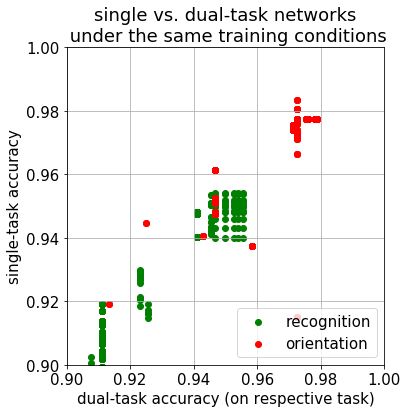

In [226]:
# space_dim_names = ['learning_rate', 'lambda_l2', 'n_nodes']
# space_dim_names = ['learning_rate', 'lambda_l2', 'n_nodes', 'run_name']
space_dim_names = ['learning_rate', 'lambda_l2', 'num_weights', 'performance', 'performance_orient']
fig, ax = plt.subplots(1, 1)
# print(df.describe())
dfd_ro = df.query('task_recognition == True and task_orientation == True')[space_dim_names]#.loc[:20]
dfd_o = df.query('task_recognition == False and task_orientation == True')[space_dim_names]#.loc[:20]
dfd_r = df.query('task_recognition == True and task_orientation == False')[space_dim_names]#.loc[:20]
# print('ro')
# print(dfd_ro)
# print('o')
# print(dfd_o.describe())
s1 = pd.merge(dfd_r, dfd_o, how='inner', on=['learning_rate', 'lambda_l2', 'num_weights'])
# print(s1.describe())
s1 = pd.merge(s1, dfd_ro, how='inner', on=['learning_rate', 'lambda_l2', 'num_weights'])
# print(s1.describe())
plt.axes().set_aspect('equal')
plt.scatter(s1.performance, s1.performance_x, color='g', label='recognition')
plt.scatter(s1.performance_orient, s1.performance_orient_y, color='red', label='orientation')
plt.xlabel('dual-task accuracy (on respective task)')
plt.ylabel('single-task accuracy')
plt.title('single vs. dual-task networks\n under the same training conditions')
plt.grid()
# print(s1[['performance_x', 'performance_orient_y']].dtypes)
plt.xlim([0.9,1.0])
plt.ylim([0.9,1.0])
plt.legend(loc='lower right')
plt.tight_layout()
# s1[['performance', 'performance_x']].astype(float).corr(method='pearson', min_periods=1)
# s1[['performance', 'performance_x']].astype(float).corr(method='spearman', min_periods=1)
# s1[['performance_orient', 'performance_orient_y']].astype(float).corr(method='pearson', min_periods=1)
s1[['performance_orient', 'performance_orient_y']].astype(float).corr(method='spearman', min_periods=1)
# print(s1.loc[3])
# print(dfd_ro.loc[64])
# print(dfd_ro.loc[dfd_ro.performance == s1.loc[0].performance_x])
# dfd = df[['learning_rate', 'lambda_l2', 'n_nodes', 'run_name', 'performance']]
# #.drop_duplicates(subset=space_dim_names, keep=False)
# print(dfd)
# # print(dfd)
# dfd = dfd.pivot('run_name', 'lambda_l2', 'performance')
# print(dfd)
# X = dfd.columns.values
# Y = dfd.index.values
# Z = dfd.values
# x, y = np.meshgrid(X, Y)
# ax.contourf(x, y, Z)
# print(X)
# print(Y)
# print(Z)

AttributeError: 'AxesSubplot' object has no attribute 'set_yabel'

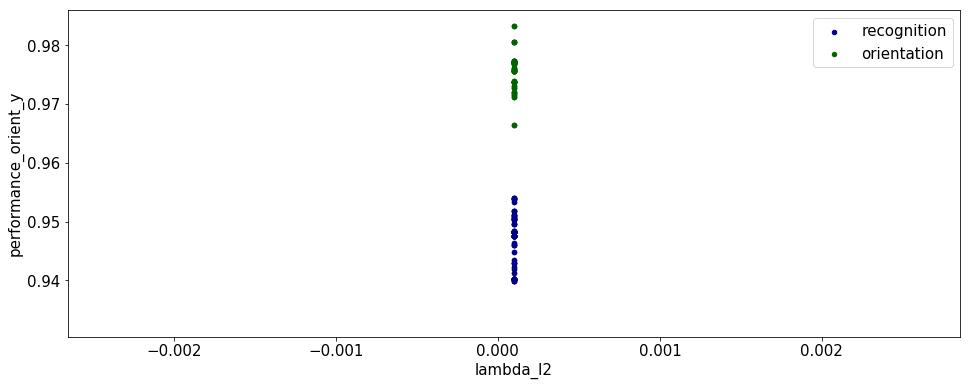

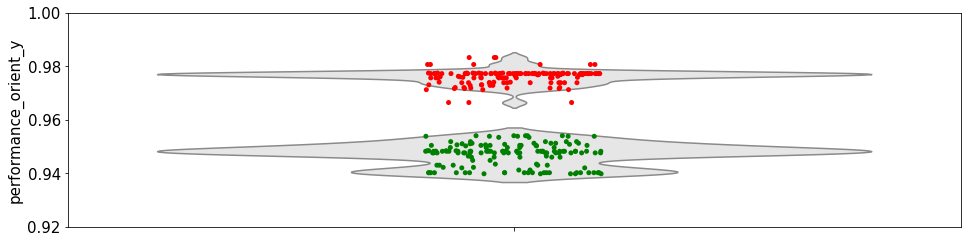

In [202]:
# print(s1.describe())
px = s1.query('performance_orient > 0.96 and performance_orient_y > 0.96')
py = s1.query('performance > 0.94 and performance_orient_y > 0.94')
# pxy = pd.DataFrame({'recognition':px,'orientation':py})
# print(pxy)
# ax = sns.stripplot(y=["r",'o'], data=pxy, jitter=True)
# plt.scatter(y=["r",'o'], data=pxy, jitter=True)
ax = px.plot.scatter(x=1, y='performance_x', color='DarkBlue', label='recognition');
py.plot.scatter(x=1, y='performance_orient_y', color='DarkGreen', label='orientation', ax=ax);

plt.figure()
# ax = sns.violinplot(x="day", y="total_bill", data=tips,
# ...                     inner=None, color=".8")

plt.axes().set_aspect(3)
ax = sns.violinplot(y='performance_x', data=px, jitter=True, label='recognition', inner=None,color=".9")
ax = sns.stripplot(y='performance_x', data=px, jitter=True, color='Green', label='recognition')
ax = sns.violinplot(y='performance_orient_y', data=py, jitter=True, label='orientation', inner=None,color=".9")
ax = sns.stripplot(y='performance_orient_y', data=py, jitter=True, color='Red', label='orientation')
# ax = sns.stripplot(y='performance_orient_y', data=py, jitter=False, color='Red', label='orientation')
ax.set_ylim([0.92,1.])
ax.set_yabel("accuracy")
ax.legend()
ax.tight_layout()

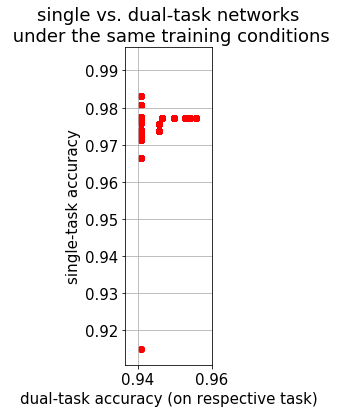

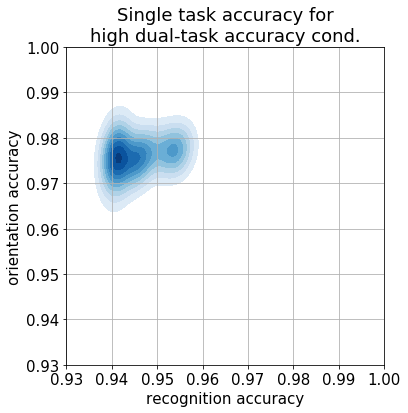

In [234]:
# print(s1.describe())
px = s1.query('performance_orient > 0.96 and performance_orient_y > 0.96')
# print(px.describe())
py = s1.query('performance > 0.94 and performance_x > 0.94')
# print(py.describe())
plt.axes().set_aspect('equal')
plt.scatter(px.performance, px.performance_orient_y, color='b')
plt.scatter(py.performance, py.performance_orient_y, color='r')
plt.xlabel('dual-task accuracy (on respective task)')
plt.ylabel('single-task accuracy')
plt.title('single vs. dual-task networks\n under the same training conditions')
plt.grid()
# plt.legend(loc='lower right')
plt.tight_layout()
plt.figure()

plt.axes().set_aspect('equal')
# x = np.hstack((np.array(px.performance), np.array(py.performance)))
# y = np.hstack((np.array(px.performance_orient_y), np.array(py.performance_orient_y)))
# ax = sns.kdeplot(x, y)
# ax = sns.kdeplot(np.array(px.performance), np.array(px.performance_orient_y), cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(np.array(py.performance), np.array(py.performance_orient_y), cmap="Blues", shade=True, shade_lowest=False)
# s1[['performance', 'performance_x']].astype(float).corr(method='pearson', min_periods=1)
# s1[['performance', 'performance_x']].astype(float).corr(method='spearman', min_periods=1)
# s1[['performance_orient', 'performance_orient_y']].astype(float).corr(method='pearson', min_periods=1)
# s1[['performance_orient', 'performance_orient_y']].astype(float).corr(method='spearman', min_periods=1)
plt.xlabel('recognition accuracy')
plt.ylabel('orientation accuracy')
plt.title('Single task accuracy for\nhigh dual-task accuracy cond.')
plt.ylim([0.93,1.0])
plt.xlim([0.93,1.0])
plt.grid()
# plt.legend(loc='lower right')
plt.tight_layout()